# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---

## Step 0: Load The Data

In [27]:
import zipfile
import pickle

data_files = ['train.zip', 'valid.zip', 'test.zip']
data_folder = './data/'

for file in data_files:
    zip_ref = zipfile.ZipFile(data_folder + file, 'r')
    zip_ref.extractall(data_folder)
    zip_ref.close()

training_file = './data/train.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

import csv
reader = csv.reader(open(data_folder + 'signnames.csv', 'r'))
signnames = {}
next(reader, None)
for row in reader:
   k, v = row
   signnames[k] = v

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

In [2]:
# Number of training samples
n_train = X_train.shape[0]

# Number of validation samples
n_validation = X_valid.shape[0]

# Number of testing samples
n_test = X_test.shape[0]

# Shape of an traffic sign image
image_shape = X_train[0].shape

# Number of unique classes/labels
n_classes = len(set(y_train) | set(y_valid) | set(y_test))

print("Number of training samples =", n_train)
print("Number of validation samples =", n_validation)
print("Number of testing samples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training samples = 34799
Number of validation samples = 4410
Number of testing samples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

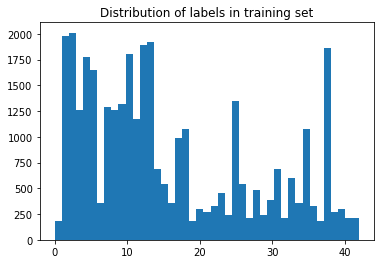

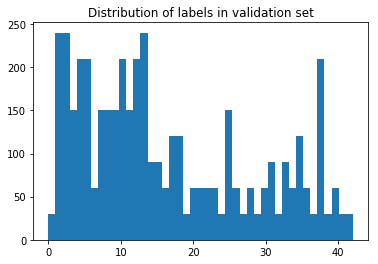

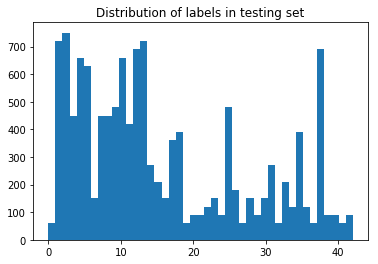

Some random image samples from training set


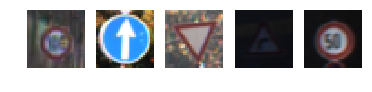

In [14]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Distribution of signs in training, validation and testing sets
plt.figure()
plt.hist(y_train, n_classes);
plt.title('Distribution of labels in training set')
plt.savefig('./images/distribution_train.jpg')
plt.figure()
plt.hist(y_valid, n_classes);
plt.title('Distribution of labels in validation set')
plt.savefig('./images/distribution_valid.jpg')
plt.figure()
plt.hist(y_test, n_classes);
plt.title('Distribution of labels in testing set')
plt.savefig('./images/distribution_test.jpg')
plt.show()

# Some random image samples from training set
print('Some random image samples from training set')
n = 5
plt.figure()
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_train[random.randint(1, n_train)])
    plt.axis('off')
plt.savefig('./images/random_signs.jpg')
plt.show()

## Step 2: Model Architecture Design and Testing

### Data Preprocessing

In [15]:
# Data normalization
X_train = X_train / 127.5 - 1.0
X_valid = X_valid / 127.5 - 1.0
X_test = X_test / 127.5 - 1.0

### Setup TensorFlow

In [16]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

### Network Architecture

In [17]:
def conv_layer(x, w, b, strides=1):
    x = tf.nn.conv2d(x, w, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool_layer(x, strides=2):
    x = tf.nn.max_pool(x, ksize=[1, strides, strides, 1], strides=[1, strides, strides, 1], padding='VALID')
    return x

def fc_layer(x, w, b):
    x = tf.matmul(x, w)
    x = tf.add(x, b)
    return x

def CNN(x):
    
    # Arguments used for tf.truncated_normal
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12.
    wc1 = tf.Variable(tf.truncated_normal([5, 5, 3, 12], mean=mu, stddev=sigma))
    bc1 = tf.Variable(tf.zeros([12]))
    cl1 = conv_layer(x, wc1, bc1)
    
    # Activation.
    cl1 = tf.nn.relu(cl1)
    
    # Pooling. Input = 28x28x12. Output = 14x14x12.
    cl1 = maxpool_layer(cl1)

    # Layer 2: Convolutional. Input = 14x14x12. Output = 10x10x24.
    wc2 = tf.Variable(tf.truncated_normal([5, 5, 12, 24], mean=mu, stddev=sigma))
    bc2 = tf.Variable(tf.zeros([24]))
    cl2 = conv_layer(cl1, wc2, bc2)
    
    # Activation.
    cl2 = tf.nn.relu(cl2)

    # Pooling. Input = 10x10x24. Output = 5x5x24.
    cl2 = maxpool_layer(cl2)

    # Flatten. Input = 5x5x24. Output = 600.
    cl2 = tf.contrib.layers.flatten(cl2)
    
    # Layer 3: Fully Connected. Input = 600. Output = 180.
    wfc3 = tf.Variable(tf.truncated_normal([600, 180], mean=mu, stddev=sigma))
    bfc3 = tf.Variable(tf.zeros([180]))
    fcl3 = fc_layer(cl2, wfc3, bfc3)
    
    # Activation.
    fcl3 = tf.nn.relu(fcl3)
    
    # Dropout.
    fcl3 = tf.nn.dropout(fcl3, keep_prob)

    # Layer 4: Fully Connected. Input = 180. Output = 130.
    wfc4 = tf.Variable(tf.truncated_normal([180, 130], mean=mu, stddev=sigma))
    bfc4 = tf.Variable(tf.zeros([130]))
    fcl4 = fc_layer(fcl3, wfc4, bfc4)
    
    # Activation.
    fcl4 = tf.nn.relu(fcl4)
        
    # Dropout.
    fcl4 = tf.nn.dropout(fcl4, keep_prob)

    # Layer 5: Fully Connected. Input = 130. Output = 43.
    wfc5 = tf.Variable(tf.truncated_normal([130, 43], mean=mu, stddev=sigma))
    bfc5 = tf.Variable(tf.zeros([43]))
    logits = fc_layer(fcl4, wfc5, bfc5)
    
    return logits

### Features and Labels

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)

### Training Pipeline

In [19]:
rate = 0.001

logits = CNN(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_loss += (loss * len(batch_x))
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples, total_loss / num_examples

### Train the Model

In [21]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy, validation_loss = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, './traffic_sign_cnn')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.727
Validation Loss = 0.973

EPOCH 2 ...
Validation Accuracy = 0.868
Validation Loss = 0.479

EPOCH 3 ...
Validation Accuracy = 0.899
Validation Loss = 0.319

EPOCH 4 ...
Validation Accuracy = 0.932
Validation Loss = 0.233

EPOCH 5 ...
Validation Accuracy = 0.940
Validation Loss = 0.203

EPOCH 6 ...
Validation Accuracy = 0.952
Validation Loss = 0.169

EPOCH 7 ...
Validation Accuracy = 0.955
Validation Loss = 0.175

EPOCH 8 ...
Validation Accuracy = 0.965
Validation Loss = 0.134

EPOCH 9 ...
Validation Accuracy = 0.957
Validation Loss = 0.143

EPOCH 10 ...
Validation Accuracy = 0.959
Validation Loss = 0.145

Model saved


### Evaluate the Model

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Loss = {:.3f}".format(test_loss))

Test Accuracy = 0.944
Test Loss = 0.262


## Step 3: Model Testing on New Images

Here is model testing on 5 random traffic signs from the web

### Load and Output the Images

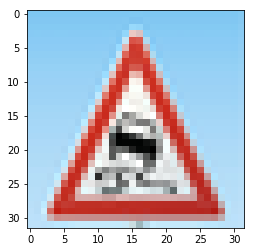

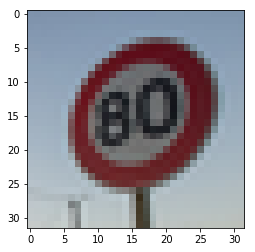

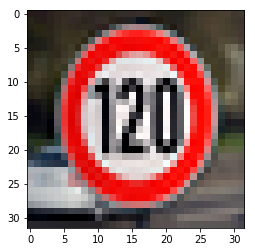

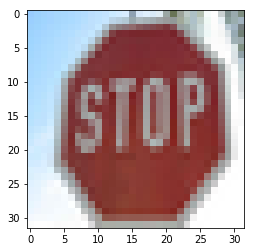

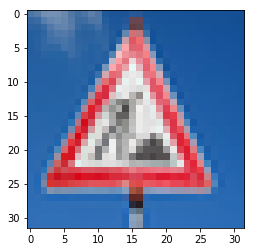

In [45]:
from PIL import Image
import numpy as np

sample_images = ['slippery_road.jpg', '80_kmh.jpg', '120_kmh.jpg', 'stop.jpg', 'road_work.jpg']
sample_folder = './data/'

sample_data = []
for file in sample_images:
    img = Image.open(sample_folder + file)
    img = img.resize((32, 32), Image.ANTIALIAS)    
    sample_data.append(np.array(img))
    plt.imshow(img)
    plt.show()

### Output Top 5 Softmax Probabilities For Each Image

In [46]:
sample_data = np.array(sample_data) / 127.5 - 1.0
   
softmax = tf.nn.softmax(logits=logits)
nn_top_k = tf.nn.top_k(softmax, k=5)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print(sess.run(nn_top_k, feed_dict={x: sample_data, keep_prob: 1.0}))

TopKV2(values=array([[  9.99983311e-01,   1.65727470e-05,   3.61731658e-08,
          2.73640097e-08,   5.12993619e-13],
       [  9.79301810e-01,   1.75401308e-02,   2.49240967e-03,
          6.64512918e-04,   8.48542015e-07],
       [  1.00000000e+00,   8.41183656e-09,   3.37481372e-13,
          1.27688972e-14,   4.87660479e-16],
       [  9.99993443e-01,   3.22659889e-06,   1.57561703e-06,
          8.44999761e-07,   6.64627578e-07],
       [  9.59331214e-01,   4.06679101e-02,   4.04650450e-07,
          2.89243332e-07,   8.11519811e-08]], dtype=float32), indices=array([[23, 30, 19, 20, 28],
       [ 5, 10,  7,  3,  2],
       [ 8,  7,  5, 28,  4],
       [14, 17, 29, 13, 15],
       [25, 31, 30, 29, 21]]))


### Predict the Sign Type for Each Image

In [48]:
print(signnames[str(23)])
print(signnames[str(5)])
print(signnames[str(8)])
print(signnames[str(14)])
print(signnames[str(25)])

Slippery road
Speed limit (80km/h)
Speed limit (120km/h)
Stop
Road work
